In [1]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install scikit-learn
!pip install accelerate==0.20.1
!pip install transformers[torch] accelerate==0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 5.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of transformers[torch] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 122.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
# Leer los datos de entrenamiento desde un archivo Excel
train_data = pd.read_excel("Valence_train_oc_es.xlsx")
train_data['Intensity'] = train_data['Intensity'].astype(np.float32)
train_data['Tweet'] = train_data['Tweet'].astype('str')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1566 non-null   object 
 1   Tweet        1566 non-null   object 
 2   Dimension    1566 non-null   object 
 3   Intensity    1566 non-null   float32
 4   Description  1566 non-null   object 
dtypes: float32(1), object(4)
memory usage: 55.2+ KB


In [4]:
train_data.head()

,ID,Tweet,Dimension,Intensity,Description
0,2018-Es-00818,Este año me tocará ir sola a la Convención de ...,valence,0.0,se infiere un estado emocional neutral or mixto
1,2018-Es-06065,MB si no me equivoco una vez me confundi de sn...,valence,0.0,se infiere un estado emocional neutral or mixto
2,2018-Es-00417,@cokep Que eres terrible fome! 🙄 Y añejo poh!,valence,-2.0,se infiere un estado emocional moderadamente n...
3,2018-Es-00861,Gracias por informar temas de contingencia del...,valence,-1.0,se infiere un estado emocional ligeramente neg...
4,2018-Es-01772,En Maipú hace falta una peluquería ATR,valence,-1.0,se infiere un estado emocional ligeramente neg...


In [5]:
# Crear el modelo de clasificación
model = RobertaForSequenceClassification.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', num_labels=1)

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [6]:
# Tokenizar los datos de entrenamiento
tokenizer = RobertaTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
train_encodings = tokenizer(train_data['Tweet'].tolist(), truncation=True, padding=True, return_tensors='pt')

# Crear el dataset para el entrenamiento
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [7]:
train_dataset = CustomDataset(train_encodings, train_data['Intensity'].tolist())


# Entrenar el modelo
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    output_dir='./results',
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

In [8]:
# Entrenar el modelo
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-6-735b7c68f53b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
10,2.951200
20,2.563700
30,1.672100
40,1.684300
50,1.568500
60,1.620200
70,1.685300
80,1.083700
90,1.454000
100,1.066000


TrainOutput(global_step=294, training_loss=0.8599917341251763, metrics={'train_runtime': 52.7457, 'train_samples_per_second': 89.069, 'train_steps_per_second': 5.574, 'total_flos': 144853668712080.0, 'train_loss': 0.8599917341251763, 'epoch': 3.0})

In [9]:
train_results = pd.DataFrame(trainer.state.log_history)
train_results[['loss','epoch','step']]

,loss,epoch,step
0,2.9512,0.10,10
1,2.5637,0.20,20
2,1.6721,0.31,30
3,1.6843,0.41,40
4,1.5685,0.51,50
5,1.6202,0.61,60
6,1.6853,0.71,70
7,1.0837,0.82,80
8,1.4540,0.92,90
9,1.0660,1.02,100


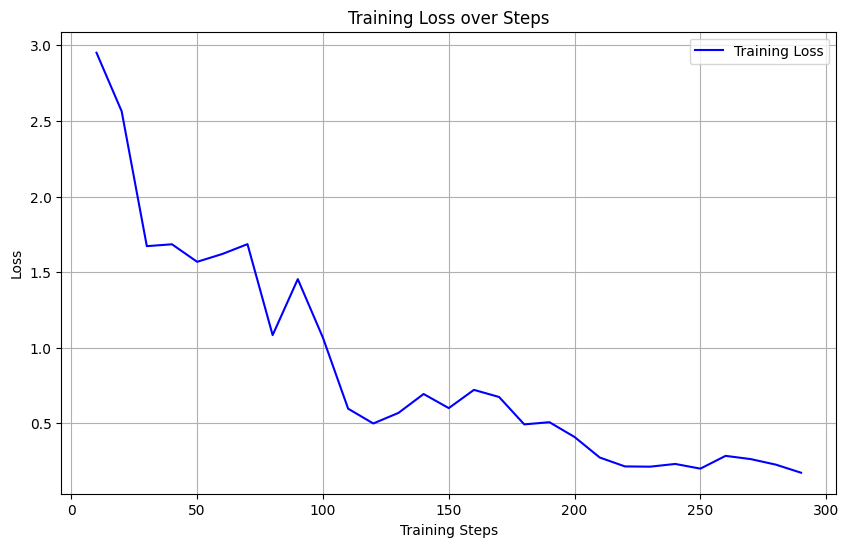

In [10]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(train_results['step'], train_results['loss'], label='Training Loss', color='blue')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def compute_metrics(p):
    predictions = p.predictions.argmax(axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [12]:
# Leer los datos de prueba desde un archivo Excel
test_data = pd.read_excel("Valence_test_oc_es.xlsx")
test_data['Intensity'] = train_data['Intensity'].astype(np.float32)
test_data['Tweet'] = train_data['Tweet'].astype('str')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           229 non-null    object 
 1   Tweet        229 non-null    object 
 2   Dimension    229 non-null    object 
 3   Intensity    229 non-null    float32
 4   Description  229 non-null    object 
dtypes: float32(1), object(4)
memory usage: 8.2+ KB


In [13]:
test_data.head()

,ID,Tweet,Dimension,Intensity,Description
0,2018-Es-00766,Este año me tocará ir sola a la Convención de ...,valence,0.0,se infiere un estado emocional moderadamente n...
1,2018-Es-01333,MB si no me equivoco una vez me confundi de sn...,valence,0.0,se infiere un estado emocional moderadamente p...
2,2018-Es-06190,@cokep Que eres terrible fome! 🙄 Y añejo poh!,valence,-2.0,se infiere un estado emocional muy negativo
3,2018-Es-05144,Gracias por informar temas de contingencia del...,valence,-1.0,se infiere un estado emocional moderadamente n...
4,2018-Es-04187,En Maipú hace falta una peluquería ATR,valence,-1.0,se infiere un estado emocional moderadamente p...


In [14]:

# Tokenizar los datos de prueba
test_encodings = tokenizer(test_data['Tweet'].tolist(), truncation=True, padding=True, return_tensors='pt')
test_dataset = CustomDataset(test_encodings, test_data['Intensity'].tolist())


eval_trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

# Evaluar el modelo
eval_results = eval_trainer.evaluate(test_dataset)

# Mostrar métricas de evaluación
print("***** Métricas de Evaluación *****")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Guardar el modelo entrenado
model.save_pretrained('./trained_model')

# Guardar el tokenizer
tokenizer.save_pretrained('./trained_model')

<ipython-input-6-735b7c68f53b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Métricas de Evaluación *****
eval_loss: 0.11732614785432816
eval_accuracy: 0.18777292576419213
eval_precision: 0.035258671650044815
eval_recall: 0.18777292576419213
eval_f1: 0.059369380940148986
eval_runtime: 0.801
eval_samples_per_second: 285.9
eval_steps_per_second: 36.206


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/merges.txt',
 './trained_model/added_tokens.json')

In [15]:

# Obtener las predicciones del modelo en el conjunto de prueba
eval_predictions = eval_trainer.predict(test_dataset)
predicted_intensity = np.round(eval_predictions.predictions.squeeze())


# Obtener los tweets, intensidades reales y predichas
tweets = test_data['Tweet'].tolist()
real_intensities = test_data['Intensity'].tolist()

# Contar las predicciones exactas
correct_predictions = np.sum(np.array(real_intensities) == np.array(predicted_intensity))

# Calcular el porcentaje de precisión
accuracy_percentage = (correct_predictions / len(real_intensities)) * 100

# Imprimir la precisión en porcentaje
print("Porcentaje de Precisión:", accuracy_percentage)
# Imprimir ejemplos de tweets con sus predicciones y etiquetas reales
for tweet, real_intensity, predicted_intensity in zip(tweets, real_intensities, predicted_intensity):
    print("Tweet:", tweet)
    print("Intensidad Real:", real_intensity)
    print("Intensidad Predicha:", predicted_intensity)
    print("------")


<ipython-input-6-735b7c68f53b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Porcentaje de Precisión: 88.20960698689956
Tweet: Este año me tocará ir sola a la Convención de DB 😬 Vamo a conocer otakus 
Intensidad Real: 0.0
Intensidad Predicha: -0.0
------
Tweet: MB si no me equivoco una vez me confundi de snap y te mande terrible escracho mio jaja,me re copa q estes estudiando el prof suerte con eso💪
Intensidad Real: 0.0
Intensidad Predicha: 1.0
------
Tweet: @cokep Que eres terrible fome! 🙄 Y añejo poh!
Intensidad Real: -2.0
Intensidad Predicha: -2.0
------
Tweet: Gracias por informar temas de contingencia del país, preguntas claves para el proceso del país. #ironía #Tolerancia0
Intensidad Real: -1.0
Intensidad Predicha: -1.0
------
Tweet: En Maipú hace falta una peluquería ATR 
Intensidad Real: -1.0
Intensidad Predicha: -1.0
------
Tweet: Datos @FPCIUDADANA y @GobiernodeChile dicen q delincuencia ha bajado, sin/emb sensación d inseguridad sigue. Gran trabajo d la prensa 
Intensidad Real: -2.0
Intensidad Predicha: -2.0
------
Tweet: @MartinezTobias1 AAAAA feliz

In [18]:
print("Porcentaje de Precisión:", accuracy_percentage)

Porcentaje de Precisión: 88.20960698689956


<ipython-input-6-735b7c68f53b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


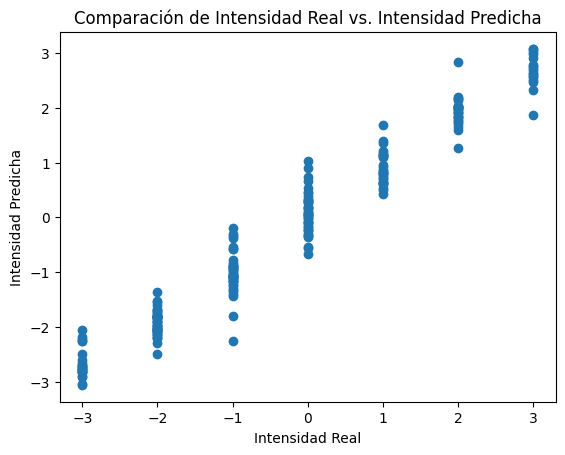

In [16]:
import matplotlib.pyplot as plt
eval_predictions = eval_trainer.predict(test_dataset)
predicted_intensity = eval_predictions.predictions.squeeze()

# Crear el gráfico de dispersión
plt.scatter(test_data['Intensity'], predicted_intensity)
plt.xlabel('Intensidad Real')
plt.ylabel('Intensidad Predicha')
plt.title('Comparación de Intensidad Real vs. Intensidad Predicha')
plt.show()

<ipython-input-6-735b7c68f53b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


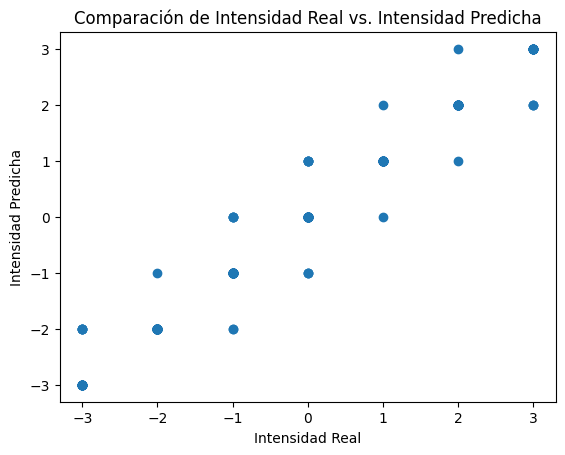

In [17]:
import matplotlib.pyplot as plt
eval_predictions = eval_trainer.predict(test_dataset)
predicted_intensity = np.round(eval_predictions.predictions.squeeze())

# Crear el gráfico de dispersión
plt.scatter(test_data['Intensity'], predicted_intensity)
plt.xlabel('Intensidad Real')
plt.ylabel('Intensidad Predicha')
plt.title('Comparación de Intensidad Real vs. Intensidad Predicha')
plt.show()